# CHB01 数据加载、去噪和STFT变换处理

本notebook用于：
1. 加载CHB01患者的预处理数据（HDF5格式）
2. 应用滤波去噪（带通滤波、带陷滤波、去除直流分量）
3. 进行STFT变换
4. 保存处理后的数据

In [173]:
import h5py
import numpy as np
import pandas as pd
import torch
from scipy.signal import butter, filtfilt, iirnotch
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import os

# 设置随机种子以保证结果可重现
np.random.seed(42)
torch.manual_seed(42)

print("所有必要的库已导入成功！")

所有必要的库已导入成功！


In [174]:
# 数据路径配置
PATIENT_ID = 23
DATA_DIR = Path("D:\\陈教授组\\mymodel\\data\\unprocessed")
PREICTAL_PATH = DATA_DIR / "preictal" / f"preictal_fragments{PATIENT_ID:02d}.h5"
INTERICTAL_PATH = DATA_DIR / "interictal" / f"interictal_fragments{PATIENT_ID:02d}.h5"

# 检查文件是否存在
print(f"正在检查患者 {PATIENT_ID:02d} 的数据文件...")
print(f"Preictal文件: {PREICTAL_PATH}")
print(f"  存在: {PREICTAL_PATH.exists()}")

print(f"Interictal文件: {INTERICTAL_PATH}")  
print(f"  存在: {INTERICTAL_PATH.exists()}")

if PREICTAL_PATH.exists() or INTERICTAL_PATH.exists():
    print("✅ 找到数据文件，可以开始处理")
else:
    print("❌ 未找到数据文件，请先运行数据预处理程序")

正在检查患者 23 的数据文件...
Preictal文件: D:\陈教授组\mymodel\data\unprocessed\preictal\preictal_fragments23.h5
  存在: True
Interictal文件: D:\陈教授组\mymodel\data\unprocessed\interictal\interictal_fragments23.h5
  存在: True
✅ 找到数据文件，可以开始处理


In [175]:
# 滤波和去噪函数定义
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """带通滤波器"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)  # 对最后一个维度（时间轴）进行滤波

def notch_filter(data, freq, fs, Q=30):
    """带陷滤波器（陷波滤波器）"""
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, data, axis=-1)

def remove_dc_component(data):
    """去除直流分量（减去每个通道的均值）"""
    return data - np.mean(data, axis=-1, keepdims=True)

def apply_all_filters(data, fs=256):
    """
    应用滤波器：带陷滤波 -> 去除直流分量 (不使用带通滤波)
    
    Args:
        data: 输入数据, shape (..., channels, timepoints)
        fs: 采样频率 (Hz)
    """
    # 1. 带陷滤波：去除57-63Hz频段的干扰（工频）
    filtered_data = notch_filter(data, 60, fs, Q=30)
    
    # 2. 带陷滤波：去除117-123Hz频段的干扰（二次谐波）
    filtered_data = notch_filter(filtered_data, 120, fs, Q=30)
    
    # 3. 去除直流分量
    filtered_data = remove_dc_component(filtered_data)
    
    return filtered_data

print("滤波函数定义完成！")

滤波函数定义完成！


In [176]:
# STFT变换函数定义
# 参数配置
n_fft = 256
win_length = 256
hop_length = 128
window = torch.hann_window(256)
center = True
return_complex = True

def apply_stft_to_data(data_array):
    """
    对三维数组应用STFT变换
    输入: (样本数, 通道数, 时间点数)
    输出: (样本数, 通道数, 频率bins, 时间frames) - 复数格式
    """
    if data_array.size == 0:
        return np.array([])
    
    n_samples, n_channels, n_timepoints = data_array.shape
    stft_list = []
    
    print(f"  正在处理 {n_samples} 个样本, 每个样本 {n_channels} 个通道...")
    
    for sample_idx in range(n_samples):
        if sample_idx % 100 == 0:  # 每100个样本显示一次进度
            print(f"    进度: {sample_idx}/{n_samples}")
            
        sample_data = data_array[sample_idx]  # (通道数, 时间点数)
        # 转为 torch tensor，float32
        sample_tensor = torch.tensor(sample_data, dtype=torch.float32)
        
        # 对每个通道分别做 stft
        stft_channels = []
        for ch in range(n_channels):
            stft_result = torch.stft(
                sample_tensor[ch],
                n_fft=n_fft,
                hop_length=hop_length,
                win_length=win_length,
                window=window,
                center=center,
                return_complex=return_complex
            )  # shape: (freq_bins, time_frames)
            stft_channels.append(stft_result)
        
        # 堆叠成 (channels, freq_bins, time_frames)
        stft_sample = torch.stack(stft_channels, dim=0)
        stft_list.append(stft_sample)
    
    # 堆叠所有样本 (样本数, 通道数, freq_bins, time_frames)
    return torch.stack(stft_list, dim=0)

print("STFT函数定义完成！")

STFT函数定义完成！


In [177]:
# 逐个处理并保存数据（减少内存占用）
def process_and_save_fragments(input_path, output_path, data_type):
    """
    逐个加载、处理并保存数据片段，减少内存占用
    
    Args:
        input_path: 输入HDF5文件路径
        output_path: 输出HDF5文件路径  
        data_type: 数据类型（'preictal' 或 'interictal'）
    """
    print(f"正在处理 {data_type} 数据...")
    
    # 确保输出目录存在
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    total_samples = 0
    fragment_count = 0
    
    # 检查输入文件是否存在
    if not input_path.exists():
        print(f"输入文件不存在: {input_path}")
        return 0, 0
    
    # 打开输入和输出文件
    with h5py.File(input_path, 'r') as input_file, h5py.File(output_path, 'w') as output_file:
        fragment_keys = list(input_file.keys())
        print(f"找到 {len(fragment_keys)} 个片段")
        
        for i, key in enumerate(fragment_keys):
            print(f"处理片段 {i+1}/{len(fragment_keys)}: {key}")
            
            # 逐个加载片段（不将所有数据加载到内存）
            raw_data = input_file[key][:]
            print(f"  原始形状: {raw_data.shape}")
            
            # 应用滤波
            filtered_data = apply_all_filters(raw_data)
            print(f"  滤波后形状: {filtered_data.shape}")
            
            # 应用STFT变换（输出复数格式）
            stft_complex = apply_stft_to_data(filtered_data)
            print(f"  STFT复数形状: {stft_complex.shape}")
            
            #把0Hz的数据直接删掉
            stft_complex = stft_complex[:, :, 1:, :]  # 删除0Hz频率分量
            print(f"  删除0Hz后STFT形状: {stft_complex.shape}")

            # 转换为对数幅度谱
            magnitude = torch.abs(stft_complex)
            log_magnitude = 20 * torch.log10(magnitude + 1e-8)
            print(f"  STFT对数幅度谱形状: {log_magnitude.shape}")
            
            # 转换为numpy
            stft_numpy = log_magnitude.numpy()
            
            # 保存对数幅度谱数据
            output_file.create_dataset(f'{key}_processed', data=stft_numpy, compression='gzip')
            
            total_samples += log_magnitude.shape[0]
            fragment_count += 1
            
            # 清理内存
            del raw_data, filtered_data, stft_complex, magnitude, log_magnitude, stft_numpy
            
            print(f"  片段 {key} 处理完成并保存")
    
    print(f"{data_type} 数据处理完成！")
    print(f"  总片段数: {fragment_count}")
    print(f"  总样本数: {total_samples}")
    print(f"  保存路径: {output_path}")
    
    return fragment_count, total_samples

# 设置输出路径
processed_dir = Path("D:\\陈教授组\\mymodel\\data\\processed")
preictal_output_path = processed_dir / "preictal" / f"stft_preictal_chb{PATIENT_ID:02d}.h5"
interictal_output_path = processed_dir / "interictal" / f"stft_interictal_chb{PATIENT_ID:02d}.h5"

# 处理preictal数据
preictal_fragments_count, preictal_total_samples = process_and_save_fragments(
    PREICTAL_PATH, preictal_output_path, "preictal"
)

# 处理interictal数据  
interictal_fragments_count, interictal_total_samples = process_and_save_fragments(
    INTERICTAL_PATH, interictal_output_path, "interictal"
)

print(f"\n=== 全部处理完成 ===")
print(f"Preictal: {preictal_fragments_count} 个片段, {preictal_total_samples} 个样本")
print(f"Interictal: {interictal_fragments_count} 个片段, {interictal_total_samples} 个样本")

正在处理 preictal 数据...
找到 6 个片段
处理片段 1/6: fragment_01
  原始形状: (719, 22, 1280)
  滤波后形状: (719, 22, 1280)
  正在处理 719 个样本, 每个样本 22 个通道...
    进度: 0/719
    进度: 100/719
    进度: 200/719
    进度: 300/719
    进度: 400/719
    进度: 500/719
    进度: 600/719
    进度: 700/719
  STFT复数形状: torch.Size([719, 22, 129, 11])
  删除0Hz后STFT形状: torch.Size([719, 22, 128, 11])
  STFT对数幅度谱形状: torch.Size([719, 22, 128, 11])
  片段 fragment_01 处理完成并保存
处理片段 2/6: fragment_02
  原始形状: (657, 22, 1280)
  滤波后形状: (657, 22, 1280)
  正在处理 657 个样本, 每个样本 22 个通道...
    进度: 0/657
    进度: 100/657
    进度: 200/657
    进度: 300/657
    进度: 400/657
    进度: 500/657
    进度: 600/657
  STFT复数形状: torch.Size([657, 22, 129, 11])
  删除0Hz后STFT形状: torch.Size([657, 22, 128, 11])
  STFT对数幅度谱形状: torch.Size([657, 22, 128, 11])
  片段 fragment_02 处理完成并保存
处理片段 3/6: fragment_03
  原始形状: (9, 22, 1280)
  滤波后形状: (9, 22, 1280)
  正在处理 9 个样本, 每个样本 22 个通道...
    进度: 0/9
  STFT复数形状: torch.Size([9, 22, 129, 11])
  删除0Hz后STFT形状: torch.Size([9, 22, 128, 11])
  STFT对数幅度谱形状: 

验证处理后的文件...
\nPREICTAL 文件验证:
  文件路径: D:\陈教授组\mymodel\data\processed\preictal\stft_preictal_chb23.h5
  文件大小: 376.56 MB
  包含数据集: 6 个
  数据格式: 对数幅度谱 (log_magnitude, dB)
    fragment_01_processed: (719, 22, 128, 11), 范围: [-160.00, 91.30] dB
    fragment_02_processed: (657, 22, 128, 11), 范围: [-86.32, 92.80] dB
    fragment_03_processed: (9, 22, 128, 11), 范围: [-44.03, 85.54] dB
    fragment_04_processed: (719, 22, 128, 11), 范围: [-160.00, 95.19] dB
\nINTERICTAL 文件验证:
  文件路径: D:\陈教授组\mymodel\data\processed\interictal\stft_interictal_chb23.h5
  文件大小: 1083.82 MB
  包含数据集: 5 个
  数据格式: 对数幅度谱 (log_magnitude, dB)
    fragment_01_processed: (957, 22, 128, 11), 范围: [-160.00, 91.65] dB
    fragment_02_processed: (2880, 22, 128, 11), 范围: [-160.00, 92.77] dB
    fragment_03_processed: (2517, 22, 128, 11), 范围: [-97.14, 94.64] dB
    fragment_04_processed: (2880, 22, 128, 11), 范围: [-160.00, 91.61] dB
\n加载并可视化处理后的数据...
Preictal可用数据片段: ['fragment_01_processed', 'fragment_02_processed', 'fragment_03_processed',

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17352\1086144746.py:86: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17352\1086144746.py:86: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17352\1086144746.py:86: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17352\1086144746.py:86: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17352\1086144746.py:86: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_173

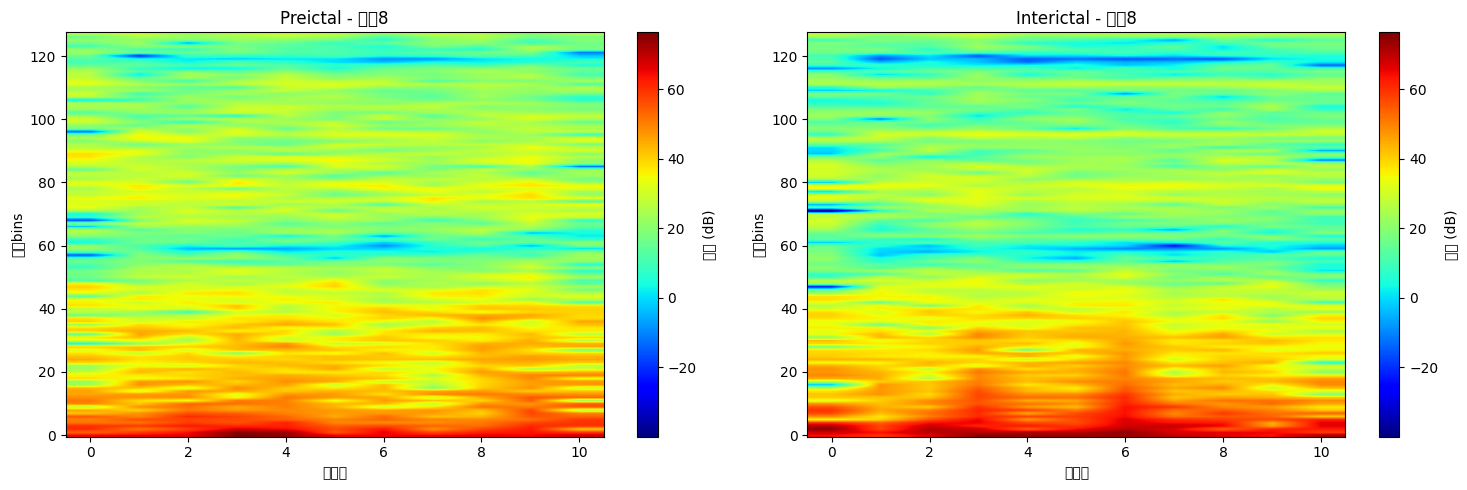


=== 通道8对比统计 ===
Preictal:
  形状: (128, 11)
  范围: [-22.73, 76.35] dB
  均值: 28.33 dB
  标准差: 13.77 dB
Interictal:
  形状: (128, 11)
  范围: [-39.90, 74.84] dB
  均值: 26.27 dB
  标准差: 16.47 dB

可视化完成！对比了通道8的preictal和interictal数据


In [178]:
# 数据可视化（对比同一通道的preictal和interictal数据）
def load_and_visualize_processed_data():
    """
    从处理后的文件中加载少量数据进行可视化，对比preictal和interictal
    """
    processed_dir = Path("D:\\陈教授组\\mymodel\\data\\processed")
    preictal_file = processed_dir / "preictal" / f"stft_preictal_chb{PATIENT_ID:02d}.h5"
    interictal_file = processed_dir / "interictal" / f"stft_interictal_chb{PATIENT_ID:02d}.h5"
    
    # 检查文件是否存在
    if not preictal_file.exists():
        print("Preictal文件不存在，请先运行处理程序")
        return
    if not interictal_file.exists():
        print("Interictal文件不存在，请先运行处理程序")
        return
    
    # 读取preictal数据
    preictal_data = None
    with h5py.File(preictal_file, 'r') as f:
        keys = list(f.keys())
        print(f"Preictal可用数据片段: {[k for k in keys if k.endswith('_processed')]}")
        
        if len(keys) >= 1:
            log_mag_key = [k for k in keys if k.endswith('_processed')][0]
            preictal_data = f[log_mag_key][0:1]  # 只加载第一个样本
            print(f"Preictal数据形状: {preictal_data.shape}")
            
            # 确保数据是实数
            if np.iscomplexobj(preictal_data):
                print("检测到preictal复数数据，转换为实数...")
                preictal_data = np.abs(preictal_data)
    
    # 读取interictal数据
    interictal_data = None
    with h5py.File(interictal_file, 'r') as f:
        keys = list(f.keys())
        print(f"Interictal可用数据片段: {[k for k in keys if k.endswith('_processed')]}")
        
        if len(keys) >= 1:
            log_mag_key = [k for k in keys if k.endswith('_processed')][0]
            interictal_data = f[log_mag_key][0:1]  # 只加载第一个样本
            print(f"Interictal数据形状: {interictal_data.shape}")
            
            # 确保数据是实数
            if np.iscomplexobj(interictal_data):
                print("检测到interictal复数数据，转换为实数...")
                interictal_data = np.abs(interictal_data)
    
    # 如果两个数据都加载成功，进行对比可视化
    if preictal_data is not None and interictal_data is not None:
        print(f"Preictal数据范围: [{preictal_data.min():.2f}, {preictal_data.max():.2f}] dB")
        print(f"Interictal数据范围: [{interictal_data.min():.2f}, {interictal_data.max():.2f}] dB")
        
        # 选择要对比的通道
        sample_idx = 0
        channel_idx = 8  # 可以修改这个值来选择不同的通道
        
        # 提取同一通道的数据
        preictal_ch = preictal_data[sample_idx, channel_idx, :, :]
        interictal_ch = interictal_data[sample_idx, channel_idx, :, :]
        
        # 创建对比图
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # 设置统一的颜色范围以便对比
        vmin = min(preictal_ch.min(), interictal_ch.min())
        vmax = max(preictal_ch.max(), interictal_ch.max())
        
        # Preictal时频图
        im1 = axes[0].imshow(preictal_ch, aspect='auto', origin='lower', cmap="jet", 
                            interpolation='bilinear', vmin=vmin, vmax=vmax)
        axes[0].set_title(f'Preictal - 通道{channel_idx}')
        axes[0].set_xlabel('时间帧')
        axes[0].set_ylabel('频率bins')
        plt.colorbar(im1, ax=axes[0], label='幅度 (dB)')
        
        # Interictal时频图
        im2 = axes[1].imshow(interictal_ch, aspect='auto', origin='lower', cmap='jet', 
                            interpolation='bilinear', vmin=vmin, vmax=vmax)
        axes[1].set_title(f'Interictal - 通道{channel_idx}')
        axes[1].set_xlabel('时间帧')
        axes[1].set_ylabel('频率bins')
        plt.colorbar(im2, ax=axes[1], label='幅度 (dB)')
        
        plt.tight_layout()
        plt.show()
        
        # 显示统计信息
        print(f"\n=== 通道{channel_idx}对比统计 ===")
        print(f"Preictal:")
        print(f"  形状: {preictal_ch.shape}")
        print(f"  范围: [{preictal_ch.min():.2f}, {preictal_ch.max():.2f}] dB")
        print(f"  均值: {preictal_ch.mean():.2f} dB")
        print(f"  标准差: {preictal_ch.std():.2f} dB")
        
        print(f"Interictal:")
        print(f"  形状: {interictal_ch.shape}")
        print(f"  范围: [{interictal_ch.min():.2f}, {interictal_ch.max():.2f}] dB")
        print(f"  均值: {interictal_ch.mean():.2f} dB")
        print(f"  标准差: {interictal_ch.std():.2f} dB")
        
        print(f"\n可视化完成！对比了通道{channel_idx}的preictal和interictal数据")
    else:
        print("无法加载数据进行对比")

def verify_processed_files():
    """验证处理后的文件"""
    processed_dir = Path("D:\\陈教授组\\mymodel\\data\\processed")
    
    for data_type in ['preictal', 'interictal']:
        file_path = processed_dir / data_type / f"stft_{data_type}_chb{PATIENT_ID:02d}.h5"
        if file_path.exists():
            with h5py.File(file_path, 'r') as f:
                print(f"\\n{data_type.upper()} 文件验证:")
                print(f"  文件路径: {file_path}")
                print(f"  文件大小: {file_path.stat().st_size / (1024**2):.2f} MB")
                print(f"  包含数据集: {len(list(f.keys()))} 个")
                print(f"  数据格式: 对数幅度谱 (log_magnitude, dB)")
                
                # 显示前几个数据集的信息
                for i, key in enumerate(list(f.keys())[:4]):
                    data_shape = f[key].shape
                    data_range = f"[{f[key][:].min():.2f}, {f[key][:].max():.2f}]" if f[key].size > 0 else "空"
                    print(f"    {key}: {data_shape}, 范围: {data_range} dB")
        else:
            print(f"\\n{data_type.upper()} 文件不存在: {file_path}")

# 验证处理结果
print("验证处理后的文件...")
verify_processed_files()

# 可视化处理结果
print("\\n加载并可视化处理后的数据...")
load_and_visualize_processed_data()